# 0x0D Sampling Algorithms

Today, we will hands-on with three sampling algorithms:
- **Rejection sampling**: For sampling from a distribution with a known density function up to a constant factor.
- **Importance sampling**: For effectively evaluating the expectation of a distribution that is difficult to directly sample from.
- **Markov Chain Monte Carlo (MCMC)**: For sampling from a distribution that is too complex or high-dimensional to study analytically.

## 1. Rejection Sampling
Rejection sampling is a technique for generating random samples from a target distribution $p(x)$ by using a proposal distribution $q(x)$ that is easy to sample from. 

The key idea is to sample from \( q(x) \) and then accept or reject the samples based on a criterion involving the **ratio** of the two distributions.

Today we consider a $p(x)$ that is not directly sample-able, but relatively simple: 
A mixture of two Gaussians, truncated to the interval $[-5, 5]$:

$$
\tilde{p}(x) = \mathcal{N}(x; -2, 1) + 1.5 \mathcal{N}(x; 2, 0.5), -5 \leq x \leq 5
$$

Of course, you noticed that this is not a proper distribution, because it does not integrate to 1. (This is why we use the tilde $\tilde{p}(x)$ to denote it.)

Theoretically, the real distribution should integrate to 1:
$$
\exist Z, s.t. \  p(x) = \frac{\tilde{p}(x)}{Z},\ \int_{-5}^{5} p(x) dx = 1
$$
where Z is the normalization constant.

This is one of the powerful features of rejection sampling: we can sample from a distribution that is not normalized.
Although not in this case,
sometimes the normalization constant of an complicated distribution is intractable.

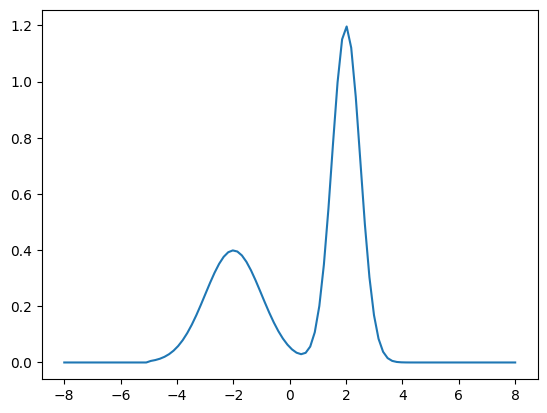

In [4]:
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def p_pdf_unnormalized(x):
    return np.where(
        (x >= -5) & (x <= 5),
        stats.norm.pdf(x, -2, 1) + 1.5 * stats.norm.pdf(x, 2, 0.5),
        0
    )

# Have a look at the distribution
x = np.linspace(-8, 8, 100)
y = p_pdf_unnormalized(x)
plt.plot(x, y)
plt.show()

Of course, this function is not easy to sample from (at least comparing to a Gaussian).

So we propose a function $q(x)$ that is easy to sample from, and satisfies:
$$
\exists \, M, s.t. \, \tilde{p}(x) \leq M q(x) , \forall x
$$

Of course, one of the easiest q(x) you can think of is a uniformed distribution over the support of the target distribution.
$$
q(x) = \frac{1}{10}, -5 \leq x \leq 5
$$

In [5]:
def q_pdf(x):
    return np.where((x >= -5) & (x <= 5), 1/10, 0)

Let us now consider the scaling factor $M$.

In [6]:
x_grid = np.linspace(-5, 5, 1000)
p_values = p_pdf_unnormalized(x_grid)
q_values = q_pdf(x_grid)
M = 1.1 * np.max(p_values / q_values)  # Add 10% for safety

print(f'M = {M:.2f}')

M = 13.17


Now we are ready to implement the rejection sampling algorithm.

Remember, we will accept samples with probability:
$$
p_{accept}(x) = \frac{\tilde{p}(x)}{Mq(x)}
$$

This could be simulated by sampling uniformly in the y-axis, and accepting the sample if the y-coordinate is below the curve of the target distribution.


In [9]:
target_sample_amount = 10000

proposed_x = np.random.uniform(-5, 5, target_sample_amount)
proposed_y = np.random.uniform(0, M, target_sample_amount)
accepted = proposed_y < p_pdf_unnormalized(proposed_x) / q_pdf(proposed_x)
accepted_x = proposed_x[accepted]
accepted_y = proposed_y[accepted]
print(f'Accepted {len(accepted_x)} samples out of {target_sample_amount} proposed samples.')

Accepted 1923 samples out of 10000 proposed samples.


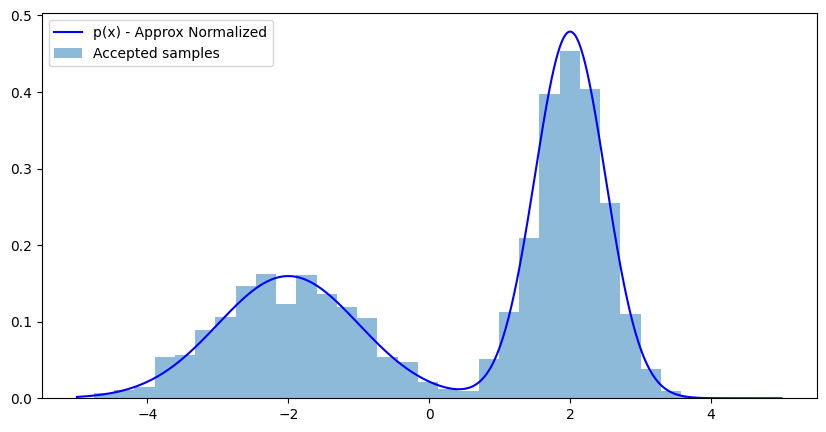

In [19]:
# Visualize the samples
def p_pdf(x):
    return np.where(
        (x >= -5) & (x <= 5),
        (1/2.5) * stats.norm.pdf(x, -2, 1) + (1.5 / 2.5) * stats.norm.pdf(x, 2, 0.5),
        0
    )

plt.figure(figsize=(10, 5))
plt.plot(x_grid, p_pdf(x_grid), label='p(x) - Approx Normalized', color='blue')
plt.hist(accepted_x, bins=30, density=True, alpha=0.5, label='Accepted samples')
plt.legend()
plt.show()